## Bayesian Optimisation Verification

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy import stats
from scipy.stats import norm
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist
from scipy.optimize import fsolve
import math

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Trial on TiOx/SiOx
Tempeature vs. S10_HF

In [2]:
#import timestamp from data sheet (time:0~5000s) 
address = 'data/degradation.xlsx'
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [0],names = None,nrows = 5000)
df_time = df.values.tolist()

In [3]:
#import data sheet at 85 C (time:0~5000s) 

df = pd.read_excel(address,sheet_name = 'normal data',usecols = [3],names = None,nrows = 5000)
df_85 = df.values.tolist() 
df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [3],names = None,nrows = 5000)
df_85s = df.values.tolist()

In [4]:
# Format date into numpy array format
x_normal = np.array(df_time).T
y_normal = np.array(df_85).T 
x_normal = x_normal.reshape((5000))
y_normal = y_normal.reshape((5000))

x_7_5000 = np.array([0,99,999,1999,2999,3999,4999])

In [5]:
def plot (X,X_,y_mean,y,y_cov,gp,kernel):
    #plot function
    plt.figure()
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)

    plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),y_mean + np.sqrt(np.diag(y_cov)),alpha=0.5, color='k')
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.tight_layout()

In [6]:
# Find the minimum value in the bound
# 5000 * 5000
# Find minimum value in the last row as the minimum value for the bound

def ucb(X , gp, dim, delta):
    """
    Calculates the GP-UCB acquisition function values
    Inputs: gp: The Gaussian process, also contains all data
            x:The point at which to evaluate the acquisition function 
    Output: acq_value: The value of the aquisition function at point x
    """
    mean, var = gp.predict(X[:, np.newaxis], return_cov=True)
    mean = np.atleast_2d(mean).T
    var = np.atleast_2d(var).T  
    beta = 2*np.log(np.power(5000,2.1)*np.square(math.pi)/(3*delta))
    return mean - np.sqrt(beta)* np.sqrt(np.diag(var))


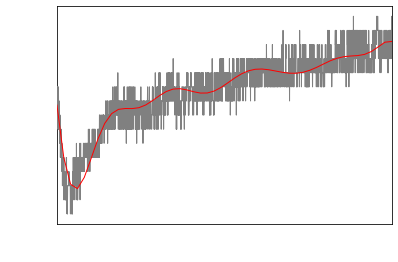

In [7]:
# Preparing training set as whole dataset to make prediction
x_loop = np.arange(0,5000,100)
# print(x_loop)
X = x_loop.reshape(x_loop.size)
y = y_normal[x_loop]
X = X.reshape(x_loop.size,1)
X_ = np.linspace(0,5000, 5000)
# Kernel setting
length_scale_bounds_MAX = 800
length_scale_bounds_MIN = 1e-4
kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.0001)
# Retrieve gp predict data
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, y)
y_mean= gp.predict(x_loop[:, np.newaxis])
# Get ucb prediction
# acp_value = ucb(X_, gp, 0.1, 5)
# X_min = np.argmin(acp_value[-1])
# ucb_y_min = acp_value[-1]
# ucb_y_max = acp_value[0]

plt.figure()
plt.plot(x_normal, y_normal, c='grey', lw=1, zorder=5)
# plt.plot(X_, ucb_y_min, 'x', lw=1, zorder=7)
# plt.scatter(X, y,c='r', s=1, zorder=6)
plt.plot(x_loop, y_mean,c='r', lw=1, zorder=6)
# plt.plot(x_normal, ucb_y_min , c='blue', lw=1, zorder=4)
# plt.plot(x_normal, ucb_y_max , c='blue', lw=1, zorder=4)

plt.tick_params(axis='y', colors = 'white')
plt.tick_params(axis='x', colors = 'white')
plt.ylabel('Lifetime',color = 'white')
plt.xlabel('Time',color = 'white')
plt.xlim(0,4900)
# plt.ylim(0.73,0.8)
# plt.tight_layout()
plt.savefig('myimage.jpg', format='jpg', dpi=1200)


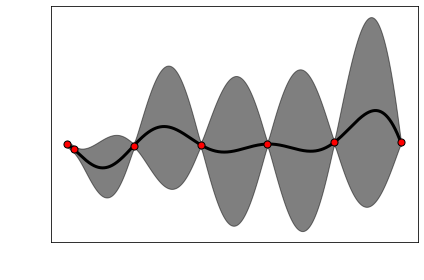

In [8]:
# Preparing training set from a few data points
# 
x_loop = x_7_5000
X = x_normal[x_loop].reshape(x_loop.size)
y = y_normal[x_loop]
X = X.reshape(x_loop.size,1)

X_ = np.linspace(0,5000, 5000)

# Kernel setting
length_scale_bounds_MAX = 800
length_scale_bounds_MIN = 1e-4

kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.00000001)
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, y)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plot (X,X_,y_mean,y,y_cov,gp,kernel)

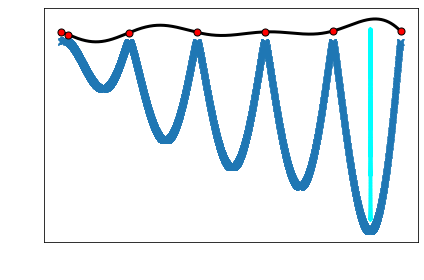

In [9]:
# Preparing training set
x_loop = x_7_5000
X = x_normal[x_loop].reshape(x_loop.size)
y = y_normal[x_loop]
X = X.reshape(x_loop.size,1)
X_ = np.linspace(0,5000, 5000)
# Kernel setting
length_scale_bounds_MAX = 900
length_scale_bounds_MIN = 1e-4
kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.0001)
# Retrieve
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, y)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
acp_value = ucb(X_, gp, 0.1, 5)
ucb_y_min = acp_value[-1]
X_min = np.argmin(acp_value[-1])

X_min_list = np.full(5000,X_min)

plt.figure()
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.plot(X_, ucb_y_min, 'x', lw=1, zorder=7)
plt.scatter(X_min_list, acp_value[X_min],c='cyan', s=5, zorder=11)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.tick_params(axis='y', colors = 'white')
plt.tick_params(axis='x', colors = 'white')
plt.ylabel('Lifetime',color = 'white')
plt.xlabel('Time',color = 'white')
plt.tight_layout()


In [10]:
def newplot(X,Y,X_, y_mean,ucb_y_min):
    plt.figure()
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean, ucb_y_min,alpha=0.5, color='k')
    plt.scatter(X[:, 0], Y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.scatter(np.argmin(ucb_y_min),min(ucb_y_min),c='g', s=50)
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.tight_layout()
    plt.show()

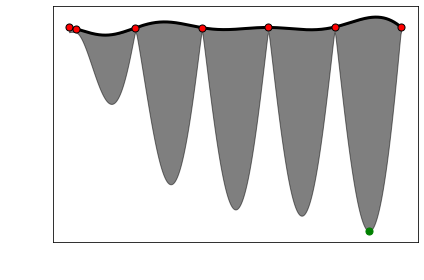

New x value: 4517 y value: 0.74822 
All x values: [   0   99  999 1999 2999 3999 4517 4999]


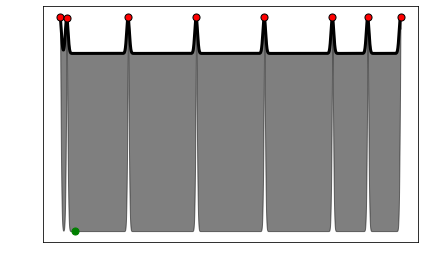

New x value: 219 y value: 0.73822 
All x values: [   0   99  219  999 1999 2999 3999 4517 4999]


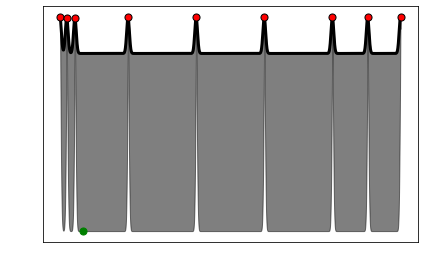

X: [[   0]
 [  99]
 [ 219]
 [ 999]
 [1999]
 [2999]
 [3999]
 [4517]
 [4999]] 
Y: [0.74622 0.73922 0.73822 0.74422 0.74522 0.74622 0.74822 0.74822 0.74822]


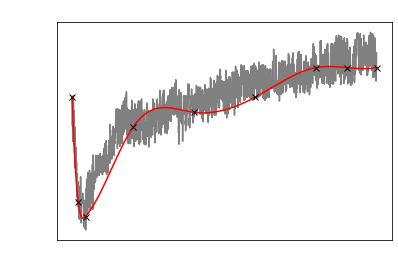

In [12]:
# Iterate i times with mins value point of each ucb bound
# Initiate with 7 data points, apply log transformation to them
x_loop = x_7_5000 
# x_loop = np.array([[0,99,999,1999,2999,3999,45000,4999]])
X = x_normal[x_loop].reshape(x_loop.size)
Y = y_normal[x_loop]
X = X.reshape(x_loop.size,1)
X_ = np.linspace(0,5000, 5000)
# Kernel setting
length_scale_bounds_MAX = 700
length_scale_bounds_MIN = 0.01
kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.0001)
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)

# Find the prediction by 
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
acp_value = ucb(X_, gp, 0.1, 5)
ucb_y_min = acp_value[-1]
newplot(X,Y,X_, y_mean,ucb_y_min)

# Change i to set extra data points
i=0

while i < 2:
    # Find minimum y value in ucb
    index = np.argmin(acp_value[-1])

    # Protection to stop equal x value
    while index in x_loop:
        index = index -  50
    x_loop = np.append(x_loop, index)
    x_loop = np.sort(x_loop)
    # Update X and Y with extra data point
    print ('New x value:',index,'y value:',y_normal[index], '\nAll x values:',x_loop)
    X = x_normal[x_loop].reshape(x_loop.size)
    Y = y_normal[x_loop]
    X = X.reshape(x_loop.size,1)
    # Update kernel in every interration
    length_scale_bounds_MAX = length_scale_bounds_MAX*10
    length_scale_bounds_MIN = 0.0001*10
    kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.0001)
    # Update gp and plot relevant infomation and plot the new graph
    gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)
    y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
    acp_value = ucb(X_, gp, 0.1, 5)
    ucb_y_min = acp_value[-1]
    newplot(X,Y,X_, y_mean,ucb_y_min)

    i+=1
# Result after a few interations
print('X:', X, '\nY:', Y)
s = interpolate.InterpolatedUnivariateSpline(x_loop,Y)
x_uni = np.arange(0,5000,1)
y_uni = s(x_uni)

# Plot figure
plt.plot(df_time,df_85s,'-',color = 'gray')
plt.plot(x_uni,y_uni,'-',color = 'red')
plt.plot(x_loop,  Y,'x',color = 'black')
plt.tick_params(axis='y', colors = 'white')
plt.tick_params(axis='x', colors = 'white')
plt.ylabel('Lifetime',color = 'white')
plt.xlabel('Time',color = 'white')
plt.title('cycle %d'%(i+1), color = 'white')


plt.show()